# Energy Consumption Forecast with LSTM Networks

In this notebook, we will build and evaluate recurrent neural networks—specifically LSTM variants—to forecast future electricity demand in Spain. By leveraging past observations of demand, generation, pricing, and weather, we aim to predict the next seven days of hourly energy demand. This notebook is organized as follows:

1. **Dataset Overview**  
   - We use an hourly time‐series dataset containing:
     - **Electricity demand** (total load)  
     - **Generation by source** (e.g., solar, wind, hydro)  
     - **Electricity price** (€/MWh)  
     - **Weather variables** (temperature, humidity, wind speed)  
   - We will inspect the dataset’s time span, missing‐value patterns, and basic summary statistics to understand its characteristics.

2. **Exploratory Data Analysis (EDA)**  
   - Plot the hourly demand curve over time to highlight daily and seasonal patterns.  
   - Visualize correlations between demand and features like temperature or wind generation.  
   - Identify any gaps or outliers that require cleaning.

3. **Data Preprocessing & Feature Engineering**  
   - **Impute missing values** using interpolation or forward/backward filling.  
   - **Normalize/standardize** each feature to zero mean and unit variance.  
   - **Construct sliding‐window sequences**:
     - For each target date \(t\), gather the previous 168 hours (7 days × 24 hours) of all input variables.  
     - Each input sequence has shape \((168, \, \text{num_features})\).  
     - The corresponding target is the 168‐hour demand sequence for hours \(t+1\) through \(t+168\).

4. **LSTM Model Architectures**  
   We will implement and compare three different architectures in PyTorch:
   - **Vanilla LSTM**:  
     - A single‐layer LSTM that processes the 168‐hour input sequence.  
     - A fully connected (dense) head that maps the final hidden state to a 168‐hour demand forecast.  
   - **Stacked LSTM**:  
     - Two LSTM layers in sequence, allowing the second layer to capture higher‐level temporal features.  
     - A dense output layer converting the last hidden state to a 168‐hour prediction.  
   - **Bidirectional LSTM (BiLSTM)**:  
     - An LSTM layer that reads the input sequence both forward and backward.  
     - Concatenate the forward and backward hidden states and feed them into a fully connected layer for the final 168‐hour forecast.

5. **Training Strategy**  
   - **Train/validation split**: Use the first 80% of chronological data for training and the remaining 20% for validation, ensuring no data leakage across time.  
   - **Loss function**: Mean Squared Error (MSE) averaged over the 168‐hour output horizon.  
   - **Optimizer**: Adam with a learning rate to be tuned.  
   - **Batch size**: Chosen based on GPU memory constraints (e.g., 32 or 64).  
   - **Early stopping**: Monitor validation loss each epoch and stop training if no improvement is seen for a fixed number of epochs (e.g., 10).

6. **Hyperparameter Selection**  
   - Perform a grid search over:
     - LSTM hidden‐state size (e.g., 64 vs. 128 units)  
     - Number of LSTM layers (1 vs. 2 for the stacked model)  
     - Learning rate (e.g., 1e-3 vs. 1e-4)  
     - Dropout rate between LSTM layers (e.g., 0.0 vs. 0.2)  
   - For each configuration:
     - Train the model and record the final validation MSE.  
     - Select the combination with the lowest validation loss.

7. **Evaluation & Visualization**  
   - Compare validation MSE across the three architectures and across hyperparameter settings.  
   - Plot “actual vs. predicted” demand curves for a sample week in the validation set to assess forecasting accuracy visually.  
   - Discuss how deeper or bidirectional LSTMs affect performance compared to the vanilla LSTM.

8. **Discussion of Results**  
   - Summarize which architecture and hyperparameter combination achieved the best validation performance.  
   - Analyze the advantages and limitations of LSTM-based forecasting for electricity demand.  
   - Reflect on:
     - The effect of sequence length (168 hours) on learning temporal dependencies.  
     - Whether bidirectional context (past + future within the window) truly helps when forecasting strictly forward.  
     - The impact of exogenous variables (weather, generation, price) on forecast accuracy.

9. **Extensions & Next Steps** (Optional)  
   - Incorporate holiday indicators or special events as additional features.  
   - Swap LSTMs with Transformer or Temporal Convolutional Network (TCN) architectures and compare performance.  
   - Build a rolling‐window prediction framework that updates forecasts in real time as new data arrive.  
   - Evaluate the model on a hold‐out test set spanning a different season (e.g., train on winter data, test on summer) to assess generalization under changing conditions.

By the end of this notebook, you will have a complete LSTM‐based pipeline for multi‐step (7 days × 24 hours) energy demand forecasting, from data preprocessing and model building through rigorous hyperparameter tuning and result interpretation.  


<a id="data_loading"></a>
# 1 - Data Loading and Dataframe Elaboration

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
#loading the data
df_energy= pd.read_csv("./data/energy_dataset.csv")
df_weather_features = pd.read_csv("./data/weather_features.csv")

print("shape of energy dataset:",df_energy.shape)
print("shape of weather features:",df_weather_features.shape)

shape of energy dataset: (35064, 29)
shape of weather features: (178396, 17)


In [4]:
#visualizaing weather dataset 
info_weather = df_weather_features.columns.to_list()
print("weather information: ", info_weather)
df_weather_features.head()

weather information:  ['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main', 'weather_description', 'weather_icon']


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [5]:
#seeing sstatistics for weather data 
df_weather_features.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


In [6]:
#analysing dtypes 
df_weather_features.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [7]:
#seeing null values 
(df_weather_features.isnull().sum()/df_weather_features.shape[0])*100

dt_iso                 0.0
city_name              0.0
temp                   0.0
temp_min               0.0
temp_max               0.0
pressure               0.0
humidity               0.0
wind_speed             0.0
wind_deg               0.0
rain_1h                0.0
rain_3h                0.0
snow_3h                0.0
clouds_all             0.0
weather_id             0.0
weather_main           0.0
weather_description    0.0
weather_icon           0.0
dtype: float64

In [8]:
#visualizing energy dataset 
energy_info = df_energy.columns.to_list()
print("energy information:",energy_info)
df_energy.head()

energy information: ['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [9]:
#seeing statistics for energy data 
df_energy.describe().T

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#visualizing dtypes
df_energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

In [11]:
#seeing null values 
(df_energy.isnull().sum()/df_energy.shape[0])*100

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

In [12]:
#veryfing the type of date cols 
from datetime import datetime
print("Is dt_iso instnace of datetime.datetime?",df_weather_features.dt_iso.map(lambda x: isinstance(x,datetime)).all())
print("Is time instnace of datetime.datetime?",df_energy.time.map(lambda x: isinstance(x,datetime)).all())

Is dt_iso instnace of datetime.datetime? False
Is time instnace of datetime.datetime? False


The function `create_dataframe` applys these changes:
1. If change_to_cat is `True` changes  columns in `cols_to_cat` to categoriacal and apply one hot encoding for these variables.
2. If remove_cols is `True` remove columns that are in `cols_to_remove`.
3. From the columns in date_cols, creates new columns with name `name_of_date_col_date` that has the values from date_cols convert to datetime `(%Y-%m-%d)`. At the end, the data is grouped by the column informed in `datecol_to_group` and the values are aggregated by the `agg_func` (by default applies the mean).
4. If break_time_cols is `True` then its returns the year, month and day from columns at date_cols as `date_col_year`,`date_col_month` and `date_col_day`.
5. If rename_cols is `True` then the column names are changed from `name of the column` to `name_of_the_column`.

In [13]:
#creating dataset
from sklearn.preprocessing import OneHotEncoder
def create_dataframe(dataset,date_cols=[],rename_columns=False,
                   remove_cols=False,cols_to_remove=[],
                   datecol_to_group=None,break_time_cols=False,agg_func='mean',
                   change_to_cat=False,cols_to_cat=[]):
    
    new_dataset = dataset.copy()
    #change col to categorical applying one hot encode for categorical cols
    if change_to_cat:
        ohe = OneHotEncoder().fit(new_dataset.loc[:,cols_to_cat])
        for col in cols_to_cat:
            new_dataset[f"{col}"] = pd.Categorical(new_dataset[f"{col}"])
        new_cat_cols = [f"is_{c}" for c in ohe.categories_[0]]
        new_dataset.loc[:,new_cat_cols] = ohe.transform(new_dataset.loc[:,cols_to_cat]).toarray()
    #remove cols
    if remove_cols:
        new_dataset = new_dataset.drop(labels=cols_to_remove,axis=1)
    #convert the date columns to timestamp and create a new column just for date
    if len(date_cols)>0:
        for col in date_cols:
            new_dataset[f"{col}_date"] = [datetime.fromisoformat(d).date() for d in new_dataset[f"{col}"]]
    #break the date by year,month and day
    if break_time_cols:
        for col in date_cols:
            new_dataset[f"{col}_year"] = [d.year for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_month"] = [d.month for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_day"] = [d.day for d in new_dataset[f"{col}_date"]]
    #remove blank spaces in columns and replace by "_"
    if rename_columns:
        new_c = {c:c.replace(" ","_") for c in new_dataset.columns.to_list()}
        new_dataset = new_dataset.rename(new_c,axis="columns")
    
    #create dataset with timestamp index
    new_dataframe = new_dataset.groupby([f"{datecol_to_group}_date"]).agg(agg_func,numeric_only=True)
    #rename index col
    if new_dataframe.index.name != "datetime":
        new_dataframe.index = new_dataframe.index.rename("datetime")
    
    
    return new_dataframe
    
    

In [14]:
rm_cols_enrg = ["generation hydro pumped storage aggregated","forecast solar day ahead","forecast wind offshore eday ahead",
                "forecast wind onshore day ahead", "total load forecast","price day ahead","price actual"]
rm_cols_wth = ["city_name","weather_id", "weather_description","weather_icon"]

df_enrg = create_dataframe(df_energy,date_cols=["time"],rename_columns=True,
                             datecol_to_group="time",remove_cols=True,cols_to_remove=rm_cols_enrg,break_time_cols=False)

df_wth = create_dataframe(df_weather_features,date_cols=["dt_iso"],remove_cols=True,cols_to_remove=rm_cols_wth,
                         datecol_to_group="dt_iso",break_time_cols=False,change_to_cat=True,cols_to_cat=["weather_main"])

print("shape of energy dataset:",df_enrg.shape)
print("shape of weather features dataset:",df_wth.shape)

shape of energy dataset: (1461, 21)
shape of weather features dataset: (1461, 23)


In [15]:
#visualizing energy dataframe
print("Energy dataset columns:",df_enrg.columns.to_list())
df_enrg.head()

Energy dataset columns: ['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_coal-derived_gas', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_fossil_oil_shale', 'generation_fossil_peat', 'generation_geothermal', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_marine', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_offshore', 'generation_wind_onshore', 'total_load_actual']


,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,...,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,total_load_actual
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,428.500000,257.416667,0.0,4256.750000,4246.541667,160.208333,0.0,0.0,0.0,1070.416667,...,2166.875000,0.0,7097.000000,42.250000,73.958333,1143.458333,202.166667,0.0,3708.416667,23896.750000
2015-01-02,385.291667,0.000000,0.0,3540.666667,1237.000000,198.625000,0.0,0.0,0.0,1543.666667,...,3714.958333,0.0,7105.833333,44.250000,61.375000,1252.208333,185.250000,0.0,11225.375000,27251.291667
2015-01-03,440.500000,0.000000,0.0,3444.291667,1344.250000,226.583333,0.0,0.0,0.0,1338.458333,...,3969.416667,0.0,7095.375000,78.041667,66.583333,1119.625000,203.958333,0.0,9167.416667,25110.666667
2015-01-04,397.125000,0.000000,0.0,3469.583333,2244.958333,355.416667,0.0,0.0,0.0,590.000000,...,3241.333333,0.0,7083.625000,83.708333,57.458333,2402.500000,159.291667,0.0,8065.666667,27112.625000
2015-01-05,360.764706,25.294118,0.0,4603.294118,2640.000000,322.470588,0.0,0.0,0.0,1161.588235,...,2541.529412,0.0,3932.176471,40.000000,73.470588,1085.941176,151.529412,0.0,7327.705882,22559.444444


In [16]:
#visualizing weather dataframe
print("Weather dataset columns:",df_wth.columns.to_list())
df_wth.head()

Weather dataset columns: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_clear', 'is_clouds', 'is_drizzle', 'is_dust', 'is_fog', 'is_haze', 'is_mist', 'is_rain', 'is_smoke', 'is_snow', 'is_squall', 'is_thunderstorm']


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,...,is_drizzle,is_dust,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,276.928845,276.928845,276.928845,1021.991667,75.391667,1.950000,181.600000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-02,277.897585,277.897585,277.897585,1024.441667,77.833333,1.575000,214.408333,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-03,278.817864,278.817864,278.817864,1020.741667,78.591667,1.575000,191.033333,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-04,279.630031,279.630031,279.630031,1015.858333,76.766667,1.258333,156.408333,0.0425,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.141667,0.0,0.0,0.0,0.0
2015-01-05,279.032920,279.032920,279.032920,1014.508333,81.158333,1.150000,174.300000,0.0125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0


In [17]:
print("Years for weather data")
all_years_wth = np.array([i_wth.year for i_wth in df_wth.index])
years_wth,count_values_wth = np.unique(all_years_wth,return_counts=True)
for year_wth,count_wth in zip(years_wth,count_values_wth):
    print(f"{year_wth}: {count_wth}")

print("Years for energy data")
all_years_enrg = np.array([i_enrg.year for i_enrg in df_enrg.index])
years_enrg,count_values_enrg = np.unique(all_years_enrg,return_counts=True)
for year_enrg,count_enrg in zip(years_enrg,count_values_enrg):
    print(f"{year_enrg}: {count_enrg}")

Years for weather data
2015: 365
2016: 366
2017: 365
2018: 365
Years for energy data
2015: 365
2016: 366
2017: 365
2018: 365


<a id="preprocessing"></a>
# 2 - Preprocessing Data 

Now we're going to prepare the data to the model. First, let's join the energy data with the weather data.

In [18]:
df = df_enrg.join(df_wth,on="datetime",how="inner")
print("cols:",df.columns.to_list())
df.head()

cols: ['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_coal-derived_gas', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_fossil_oil_shale', 'generation_fossil_peat', 'generation_geothermal', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_marine', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_offshore', 'generation_wind_onshore', 'total_load_actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_clear', 'is_clouds', 'is_drizzle', 'is_dust', 'is_fog', 'is_haze', 'is_mist', 'is_rain', 'is_smoke', 'is_snow', 'is_squall', 'is_thunderstorm']


,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,...,is_drizzle,is_dust,is_fog,is_haze,is_mist,is_rain,is_smoke,is_snow,is_squall,is_thunderstorm
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,428.500000,257.416667,0.0,4256.750000,4246.541667,160.208333,0.0,0.0,0.0,1070.416667,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-02,385.291667,0.000000,0.0,3540.666667,1237.000000,198.625000,0.0,0.0,0.0,1543.666667,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-03,440.500000,0.000000,0.0,3444.291667,1344.250000,226.583333,0.0,0.0,0.0,1338.458333,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2015-01-04,397.125000,0.000000,0.0,3469.583333,2244.958333,355.416667,0.0,0.0,0.0,590.000000,...,0.0,0.0,0.0,0.0,0.0,0.141667,0.0,0.0,0.0,0.0
2015-01-05,360.764706,25.294118,0.0,4603.294118,2640.000000,322.470588,0.0,0.0,0.0,1161.588235,...,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0


We're going to use the first three years for training and the last year for test. As we're going to forecast the next 7 days, is important that our dataset can be 
divided by 7 (this means that we're going to use all the full weeks from the data). 

So, in the cell below we're going to use 1092 days for training (156 full 7 days weeks) and 364 days for test (52 full 7 days weeks).

In [19]:
begin_train_date = datetime.strptime("2015-01-01","%Y-%m-%d").date() 
end_train_date = datetime.strptime("2017-12-29","%Y-%m-%d").date()
end_test_date = datetime.strptime("2018-12-29","%Y-%m-%d").date()

X_train = df.loc[(df.index > begin_train_date)&(df.index < end_train_date),~df.columns.isin(["total_load_actual"])]
y_train = df.loc[(df.index > begin_train_date)&(df.index < end_train_date),"total_load_actual"]
X_test = df.loc[(df.index>end_train_date)&(df.index<end_test_date),~df.columns.isin(["total_load_actual"])]
y_test =df.loc[(df.index>end_train_date)&(df.index<end_test_date),"total_load_actual"]

print("Number of train data: ", X_train.shape)
print("Number of test data: ",X_test.shape)

Number of train data:  (1092, 43)
Number of test data:  (364, 43)


The preprocessing cleans the data by applies these two changes:

1. Applies StandardScaler for the data, that is centers the values from the columns by it's mean. 

2. Remove columns that has more than 80% of constant values.

In [20]:
from sklearn.preprocessing import StandardScaler
def preprocessing(dataframe):
    new_dataframe = dataframe.copy()
    scaler = StandardScaler()
    #applying StandardScaler
    if len(new_dataframe.shape)>1:
        scaler.fit(new_dataframe)
        new_values = scaler.transform(new_dataframe)
        new_dataframe.loc[:,new_dataframe.columns.to_list()] = new_values
        
        #remove cols with constant values
        thr = int(dataframe.shape[0]*0.8)
        rm_cols = []
        for col in new_dataframe.columns:
            values,counts = np.unique(new_dataframe[col],return_counts=True)
            if (len(values)==1) or (np.any(counts>thr)):
                rm_cols.append(col)
                
        new_dataframe = new_dataframe.drop(labels=rm_cols,axis="columns")
        
    else:
        scaler.fit(new_dataframe.values.reshape(-1,1))
        new_values = scaler.fit_transform(new_dataframe.values.reshape(-1,1))
        new_dataframe = new_values
        
    return new_dataframe

In [21]:
new_X_train = preprocessing(X_train)
new_y_train = preprocessing(y_train)

new_X_test = preprocessing(X_test)
new_y_test = preprocessing(y_test)

print("Number of train columns",new_X_train.shape[1])
print("Number of test columns",new_X_test.shape[1])

Number of train columns 30
Number of test columns 30


As we're removing columns for the train and test data apart is important to ensure that they have the same number of columns. That is the same features are present
in train and test values. So, the function `rm_unseen_cols` removes columns that are present in `new_X_train` but not in `new_X_test` and vice-versa.

In [22]:
#remove cols that are in test but not in train and vice-versa
def rm_unseen_cols(train_df,test_df):
    cols_not_in_train = [col for col in test_df.columns if col not in train_df.columns]
    cols_not_in_test = [col for col in train_df.columns if col not in test_df.columns]
    new_X_test_df = test_df.drop(labels=cols_not_in_train,axis="columns")
    new_X_train_df = train_df.drop(labels=cols_not_in_test,axis="columns")
    
    return new_X_train_df, new_X_test_df

new_X_train, new_X_test =rm_unseen_cols(new_X_train,new_X_test)

print("Number of train columns:",new_X_train.shape[1])
print("Number of test columns:",new_X_test.shape[1])

Number of train columns: 29
Number of test columns: 29


In [23]:
#Creating train and test dataframes with new preprocessing values 


#train dataframe
train_dataframe = new_X_train
#our target 
train_dataframe["total_load_actual"] = new_y_train

#test dataframe
test_dataframe = new_X_test
#our target 
test_dataframe["total_load_actual"] = new_y_test


As we're going to forecast the next 7 days of energy demand, we need to create a history from our data. This is what the supervised function does. We're going to separate the X_train values by n_input days and y_train values are going to be the next n_out days staring from the end day of the input.

Then we're going to create the train dataloader that holds the X_train and y_train information. 

Also, we're going to create a week_test_dataset and week_train_dataset that batches our data by weeks. This will be useful for evaluating the model later.

In [24]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(101)

sequence_length = 7
batch_size = 20


features = [col for col in train_dataframe.columns if col != "total_load_actual"]
target = "total_load_actual"



def create_dataset(train_dataframe,test_dataframe,target,n_input,n_out):
    # convert history into inputs and outputs
    def to_supervised(dataframe,target, n_input=n_input, n_out=n_out):
        """
        This functions creates a history from the dataframe values and target values.
        For the X value we're going to separate the values from dataframe by n_input days.
        For the Y value we're going to get the values from the last day of input (in_end) till
        the n_out (that is the number of outputs).
        Args:
        Dataframe: pd.Dataframe. the dataframe with all the values including the values from the target
        Target: string. Name of the column that we're going to forecast
        N_input: int. The n_input days that are going to by our history. By default is 7.
        N_out: int. The size of sequence that we're going to forecast. By defeaut is 7.
        Returns:
        X,Y: np.array,np.array: The X vector has the history values from the dataset and the Y contains the history values
        that we're going to predicted. 
    """
        X, y = list(), list()
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(dataframe.shape[0]):
            # define the end of the input sequence
            in_end = in_start + n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= dataframe.shape[0]:
                x_input = dataframe.iloc[in_start:in_end,:].values
                X.append(x_input)
                y.append(dataframe[target].iloc[in_end:out_end].values)
            # move along one time step
            in_start += 1
        return np.array(X), np.array(y)
    
    xtrain,ytrain = to_supervised(train_dataframe,target)
    xtest,ytest = to_supervised(test_dataframe,target)
  
    train_dataset = TensorDataset(torch.Tensor(xtrain).to(device),torch.Tensor(ytrain).unsqueeze(2).to(device))
    test_dataset = TensorDataset(torch.Tensor(xtest).to(device),torch.Tensor(ytest).unsqueeze(2).to(device))
    
    return train_dataset,test_dataset
    
def split_dataset(dataframe):
    # split into standard weeks
    sp_df = np.array(np.split(dataframe.values, dataframe.shape[0]/7))
    return sp_df



train_dataset,test_dataset = create_dataset(train_dataframe,test_dataframe,target,n_input=7,n_out=7)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

X_train, y_train = next(iter(train_loader))

print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)

#split the dataframe by weeks  
week_train_dataset = split_dataset(train_dataframe)
week_test_dataset = split_dataset(test_dataframe)

print("Week train dataframe shape:", week_train_dataset.shape)
print("Week test dataframe  shape:", week_test_dataset.shape)

Train features shape: torch.Size([20, 7, 30])
Train target shape: torch.Size([20, 7, 1])
Week train dataframe shape: (156, 7, 30)
Week test dataframe  shape: (52, 7, 30)


<a id="creating_model"></a>
# 3 - Creating the model

In [25]:
#define LSTM class
from torch import nn
class LSTMModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim,dropout_prob,is_bidirectional=False):
        super(LSTMModel,self).__init__()
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.bidirectional = is_bidirectional

        #dimension for LSTM or BiLSTM
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True,
            bidirectional=self.bidirectional, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*self.D,output_dim)
        
    
    def forward(self,x):
        
        h0 = torch.zeros(self.layer_dim*self.D, x.size(0), self.hidden_dim,device=device).requires_grad_()
        c0 = torch.zeros(self.layer_dim*self.D, x.size(0), self.hidden_dim,device=device).requires_grad_()
        
        #we need to detach since we're doing backpropagatio through time 
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        
        return out

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

#Create Optimization Class
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # x.to(device)
        # y.to(device)
        # print(x.is_cuda, self.model.is_cuda)
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        train_preds = self.model(x.to(device))

        # Computes loss
        loss = self.loss_fn(y, train_preds)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader,batch_size=64,n_features=1, n_epochs=50):
        model_path = f'./models/{self.model}.pth'
#         print("model_path", model_path)
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}"
                )

#             if not os.path.exists(model_path):
#                 print("here")
#                 torch.save(self.model.state_dict(), model_path)
            model = self.model
        return model 
                
    # make a forecast
    def forecast(self,model, history, n_seq):
        history = np.array(history)
        data = history.reshape(history.shape[0]*history.shape[1], history.shape[2])
        # retrieve last observations for input data
        input_x = data[-n_seq:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))#.to(device)
        # forecast the next week
        with torch.no_grad():
            input_tensor = torch.tensor(input_x, dtype=torch.float32).to(device)
            pred = model(input_tensor).cpu().numpy()

        
        return pred[0]
    def evaluate_forecasts(self,actual, predicted):
        scores = list()
        if len(predicted.shape) > 2:
            predicted = predicted.squeeze(axis=2)
        # calculate an RMSE score for each day
        for i in range(actual.shape[1]):
            # calculate mse
            mse = mean_squared_error(actual[:, i], predicted[:, i])
            # calculate rmse
            rmse = sqrt(mse)
            # store
            scores.append(rmse)
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s += (actual[row, col] - predicted[row, col])**2
                score = sqrt(s / (actual.shape[0] * actual.shape[1]))
            return score, scores
    
    def evaluate_model(self,train, test, n_seq,model):
        # history is a list of weekly data
        history = [x_train for x_train in train]
        # walk-forward validation over each week
        predictions = list()
        for i in range(len(test)):
            # predict the week
            pred_sequence = self.forecast(model, history, n_seq)
            # store the predictions
            predictions.append(pred_sequence)
            # get real observation and add to history for predicting the next week
            history.append(test[i, :])
            # evaluate predictions days for each week
        predictions = np.array(predictions)
        score, scores = self.evaluate_forecasts(test[:, :, test.shape[2]-1], predictions)
        return score, scores, predictions 
        
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()
        
    # summarize scores
    def summarize_scores(self,name, score, scores):
        s_scores = ', '.join(['%.1f' % s for s in scores])
        print('%s: [%.3f] %s' % (name, score, s_scores))

<a id="training"></a>
# 4 - Training the model 

vanilla_lstm


stacked_lstm
model_bilstm
{'vanilla_lstm': LSTMModel(
  (lstm): LSTM(30, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
), 'stacked_lstm': LSTMModel(
  (lstm): LSTM(30, 200, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=200, out_features=1, bias=True)
), 'model_bilstm': LSTMModel(
  (lstm): LSTM(30, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=1, bias=True)
)}
===== training vanilla_lstm =====
[1/100] Training loss: 0.9766
[2/100] Training loss: 0.8881
[3/100] Training loss: 0.8450
[4/100] Training loss: 0.8113
[5/100] Training loss: 0.7906
[6/100] Training loss: 0.7650
[7/100] Training loss: 0.7220
[8/100] Training loss: 0.6938
[9/100] Training loss: 0.6504
[10/100] Training loss: 0.6265
[50/100] Training loss: 0.1478
[100/100] Training loss: 0.1144
model_path ./models/vanilla_lstm.pth
==== plot losses - vanilla_lstm ====== 


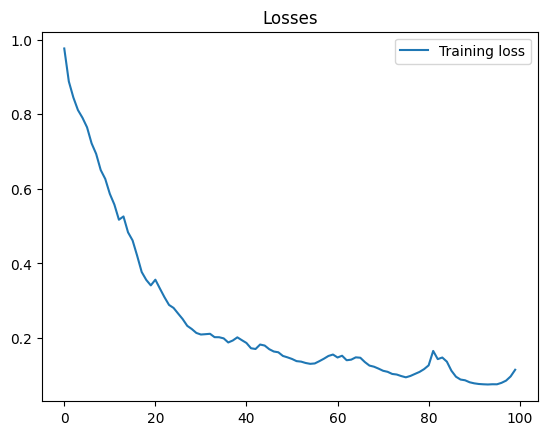

===== scores for vanilla_lstm ====
vanilla_lstm: [0.248] 1.0, 1.4, 1.1, 1.3, 1.1, 1.1, 1.1
===== training stacked_lstm =====
[1/100] Training loss: 0.9893
[2/100] Training loss: 0.9144
[3/100] Training loss: 0.8612
[4/100] Training loss: 0.8205
[5/100] Training loss: 0.7977
[6/100] Training loss: 0.7779
[7/100] Training loss: 0.7246
[8/100] Training loss: 0.6793
[9/100] Training loss: 0.6554
[10/100] Training loss: 0.6181
[50/100] Training loss: 0.1591
[100/100] Training loss: 0.0714
model_path ./models/stacked_lstm.pth
==== plot losses - stacked_lstm ====== 


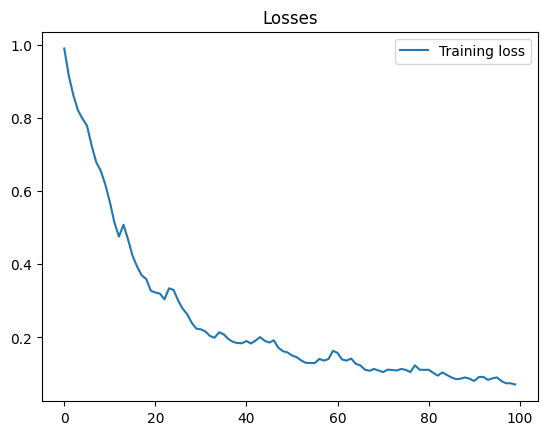

===== scores for stacked_lstm ====
stacked_lstm: [0.284] 1.1, 1.6, 0.9, 1.2, 1.0, 1.1, 1.0
===== training model_bilstm =====
[1/100] Training loss: 0.9654
[2/100] Training loss: 0.8593
[3/100] Training loss: 0.8027
[4/100] Training loss: 0.7533
[5/100] Training loss: 0.7140
[6/100] Training loss: 0.6575
[7/100] Training loss: 0.6465
[8/100] Training loss: 0.5929
[9/100] Training loss: 0.5578
[10/100] Training loss: 0.4965
[50/100] Training loss: 0.0507
[100/100] Training loss: 0.0328
model_path ./models/model_bilstm.pth
==== plot losses - model_bilstm ====== 


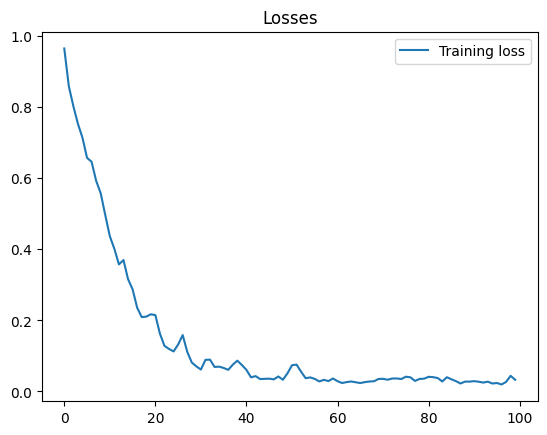

===== scores for model_bilstm ====
model_bilstm: [0.270] 1.0, 1.3, 0.9, 1.1, 1.0, 1.0, 0.9


In [27]:
import torch.optim as optim

input_dim = X_train.shape[2]
n_seq = 7
batch_size = 20
output_dim = 1
hidden_dim = 200
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'output_dim' : output_dim,
                }

models = {
    "vanilla_lstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=False,dropout_prob=0).to(device),
    "stacked_lstm":LSTMModel(**model_params,layer_dim=2,is_bidirectional=False,dropout_prob=0.2).to(device),
    "model_bilstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=True,dropout_prob=0).to(device)#
}


loss_fn = nn.MSELoss(reduction="mean")
opts = []
for name_model,model in models.items():
    print(name_model)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    opts.append((f"{name_model}",opt))
print(models)
if not os.path.exists("./models"):
    os.makedirs("./models")

predictions_by_model = {
    "vanilla_lstm":[],
    "stacked_lstm":[],
    "model_bilstm":[]
}

for name_model,opt in opts:
    print(f"===== training {name_model} =====")
    model = opt.train(train_loader, n_epochs=n_epochs,batch_size=batch_size,n_features=input_dim)
    model_path = f'./models/{name_model}.pth'
    print("model_path", model_path)
    torch.save(model, model_path)
    print(f"==== plot losses - {name_model} ====== ")
    opt.plot_losses()
    score, scores,predictions = opt.evaluate_model(week_train_dataset, week_test_dataset, n_seq,model)
    predictions_by_model[name_model].append(predictions)
    # summarize scores
    print(f"===== scores for {name_model} ====")
    opt.summarize_scores(name_model, score, scores)
    # break

In [28]:
# if not os.path.exists("./models"):
#     os.makedirs("/models")
# os.path.exists("./models")
model

LSTMModel(
  (lstm): LSTM(30, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=1, bias=True)
)

<a id="results"></a>
# 5 - Visualizing the results 

In [29]:
#inverse transform to results 

def inverse_transform(base_values, to_transform_values):
    scaler = StandardScaler()
    scaler.fit(base_values)
    new_values = scaler.inverse_transform(to_transform_values)
    return new_values


def format_predictions(predictions, values, idx_test):
    df_res = pd.DataFrame(data={"total_load_predicted_values":predictions,
                            "total_load_real_values":values},index=idx_test)
    return df_res

def plot_multiple_time_series(index,real_values,predicted_values,name_model):
    plt.figure(figsize=(20,10))
    plt.plot(index,real_values,".-y",label="real",linewidth=2)
    plt.plot(index,predicted_values,".-.r",label="predicted",linewidth=1)
    plt.legend()
    plt.xticks(rotation = 45)
    plt.title(f"{name_model} - Real x Predicted 7 Days Load Forecast");
    
def subplots_time_series(index,real_values,predicted_values,name_model):
    fig,ax = plt.subplots(2,1,sharex=True,figsize=(20,10))
    ax[0].plot(index,real_values,".-y",label="real",linewidth=1)
    ax[1].plot(index,predicted_values,".-.r",label="predicted",linewidth=1)
    
    ax[0].legend()
    ax[1].legend()
    plt.xticks(rotation = 45)
    plt.suptitle(f"{name_model} - Real and Predicted 7 Days Load Forecast");


<a id="vanilla_lstm"></a>
### Predictions for Vanilla LSTM

In [30]:
predictions_by_model

{'vanilla_lstm': [array([[[-0.2973586 ],
          [-0.7789756 ],
          [-0.45641068],
          [-0.9393361 ],
          [-0.5396051 ],
          [-0.2993444 ],
          [ 0.01868819]],
  
         [[-0.90499043],
          [ 0.1808488 ],
          [-0.31737012],
          [ 1.3744154 ],
          [ 0.13134293],
          [-1.149812  ],
          [-0.3774761 ]],
  
         [[-0.0950939 ],
          [-1.2995124 ],
          [ 0.4194111 ],
          [-0.34087074],
          [-0.19414069],
          [ 1.0237365 ],
          [ 0.62992847]],
  
         [[ 0.41936165],
          [-1.5872216 ],
          [-0.3685181 ],
          [-0.26405787],
          [-0.16617233],
          [-0.37602356],
          [-1.0826173 ]],
  
         [[-0.19198994],
          [-1.3952248 ],
          [-0.07837638],
          [-0.2566112 ],
          [-0.12096638],
          [ 0.5150485 ],
          [-0.68235624]],
  
         [[ 0.38305512],
          [-0.42063284],
          [-0.39792216],
          [ 0.

In [31]:
pred_vanilla_lstm_values = predictions_by_model["vanilla_lstm"][0].squeeze(2)
vanilla_lstm_values = np.ravel(inverse_transform(y_test.values.reshape(-1,1),pred_vanilla_lstm_values))
print(vanilla_lstm_values.shape)
vanilla_lstm_values[:10]

(364,)


array([28252.18 , 26931.758, 27816.115, 26492.107, 27588.027, 28246.736,
       29118.666, 26586.271, 29563.252, 28197.314], dtype=float32)

In [32]:
from sklearn.metrics import mean_squared_error
df_vanilla_lstm_values = format_predictions(vanilla_lstm_values,y_test,y_test.index)


print(f"RMSE for Vanilla LSTM: ",mean_squared_error(df_vanilla_lstm_values["total_load_real_values"],
     df_vanilla_lstm_values["total_load_predicted_values"]))
df_vanilla_lstm_values.head()

RMSE for Vanilla LSTM:  10473458.894011782


,total_load_predicted_values,total_load_real_values
datetime,,
2017-12-30,28252.179688,25689.041667
2017-12-31,26931.757812,24203.541667
2018-01-01,27816.115234,22462.000000
2018-01-02,26492.107422,32893.458333
2018-01-03,27588.027344,33111.458333


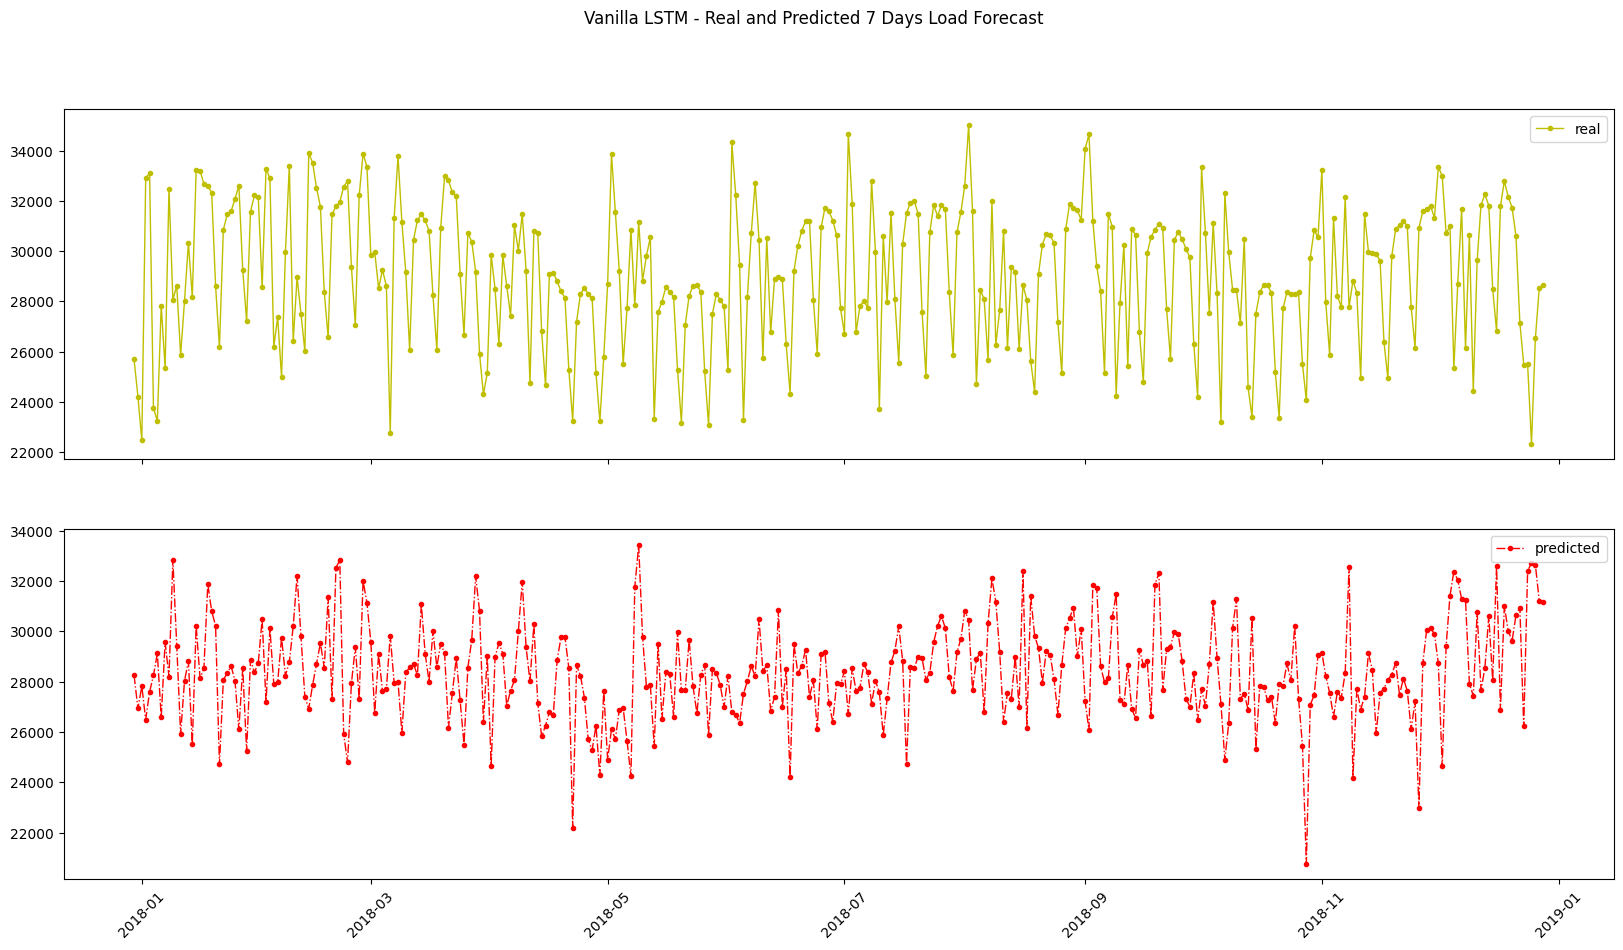

In [33]:
subplots_time_series(df_vanilla_lstm_values.index.to_list(),df_vanilla_lstm_values["total_load_real_values"],
                          df_vanilla_lstm_values["total_load_predicted_values"],"Vanilla LSTM")

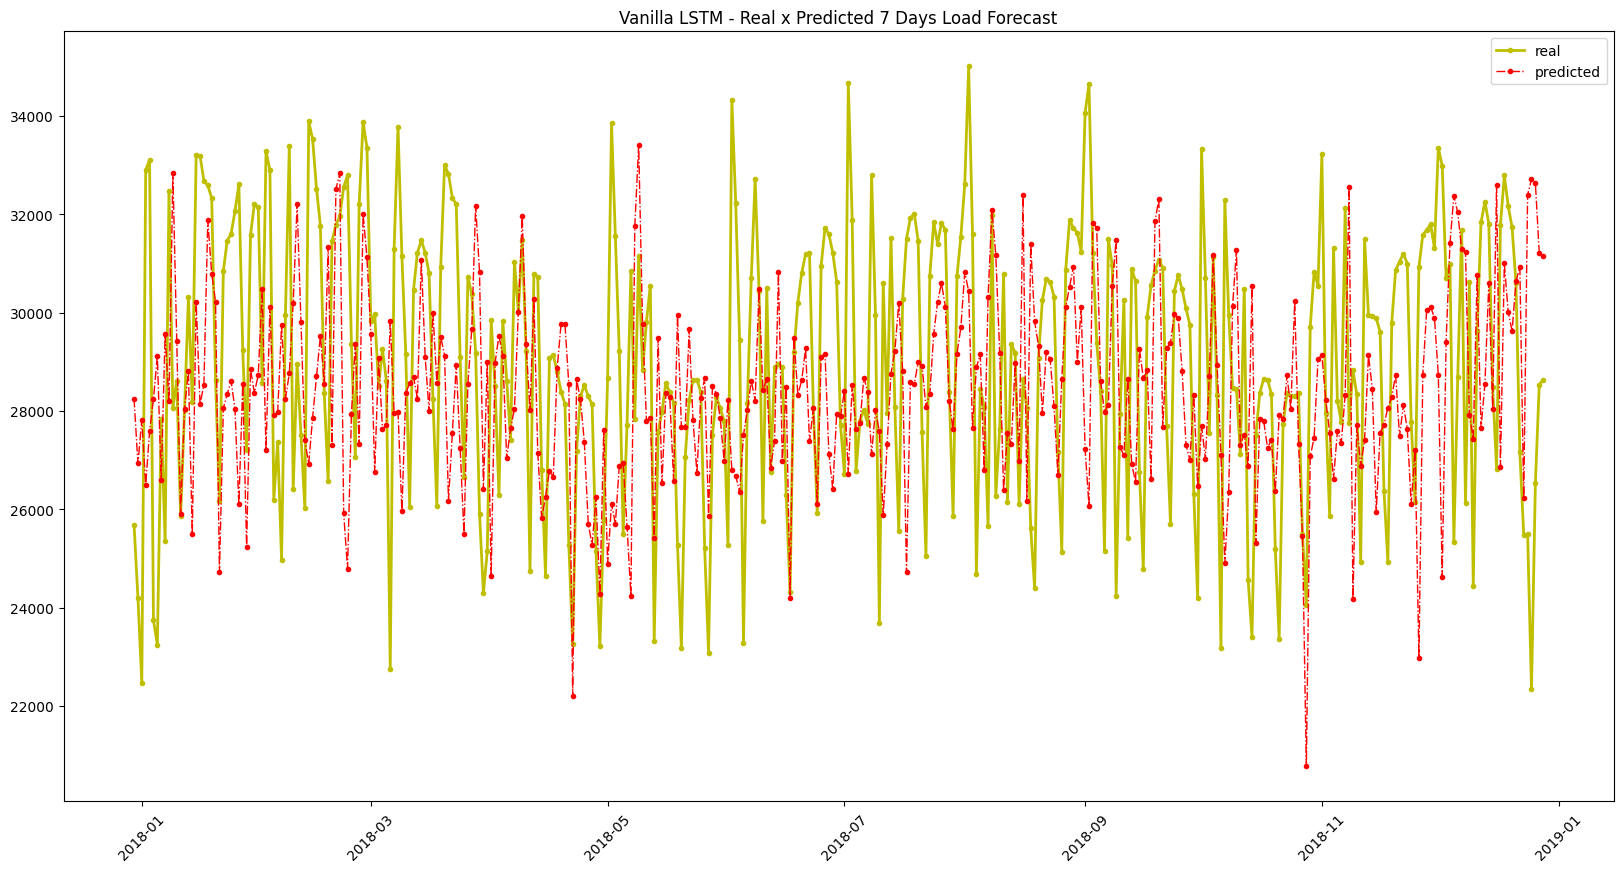

In [34]:
#plot multiple results
plot_multiple_time_series(df_vanilla_lstm_values.index.to_list(),df_vanilla_lstm_values["total_load_real_values"],
                          df_vanilla_lstm_values["total_load_predicted_values"],"Vanilla LSTM")

<a id="stacked_lstm"></a>
### Predictions for Stacked LSTM with two layers

In [35]:
pred_stacked_lstm_values = predictions_by_model["stacked_lstm"][0].squeeze(2)
stacked_lstm_values = np.ravel(inverse_transform(y_test.values.reshape(-1,1),pred_stacked_lstm_values))
print(stacked_lstm_values.shape)
stacked_lstm_values[:10]

(364,)


array([30036.893, 29038.777, 28392.662, 26617.096, 30316.318, 30240.3  ,
       30568.502, 25605.682, 31113.98 , 31998.201], dtype=float32)

In [36]:
df_stacked_lstm_values = format_predictions(stacked_lstm_values,y_test,y_test.index)


print(f"RMSE for stacked LSTM: ",mean_squared_error(df_stacked_lstm_values["total_load_real_values"],
     df_stacked_lstm_values["total_load_predicted_values"]))
df_stacked_lstm_values.head()


RMSE for stacked LSTM:  9749559.274179522


,total_load_predicted_values,total_load_real_values
datetime,,
2017-12-30,30036.892578,25689.041667
2017-12-31,29038.777344,24203.541667
2018-01-01,28392.662109,22462.000000
2018-01-02,26617.095703,32893.458333
2018-01-03,30316.318359,33111.458333


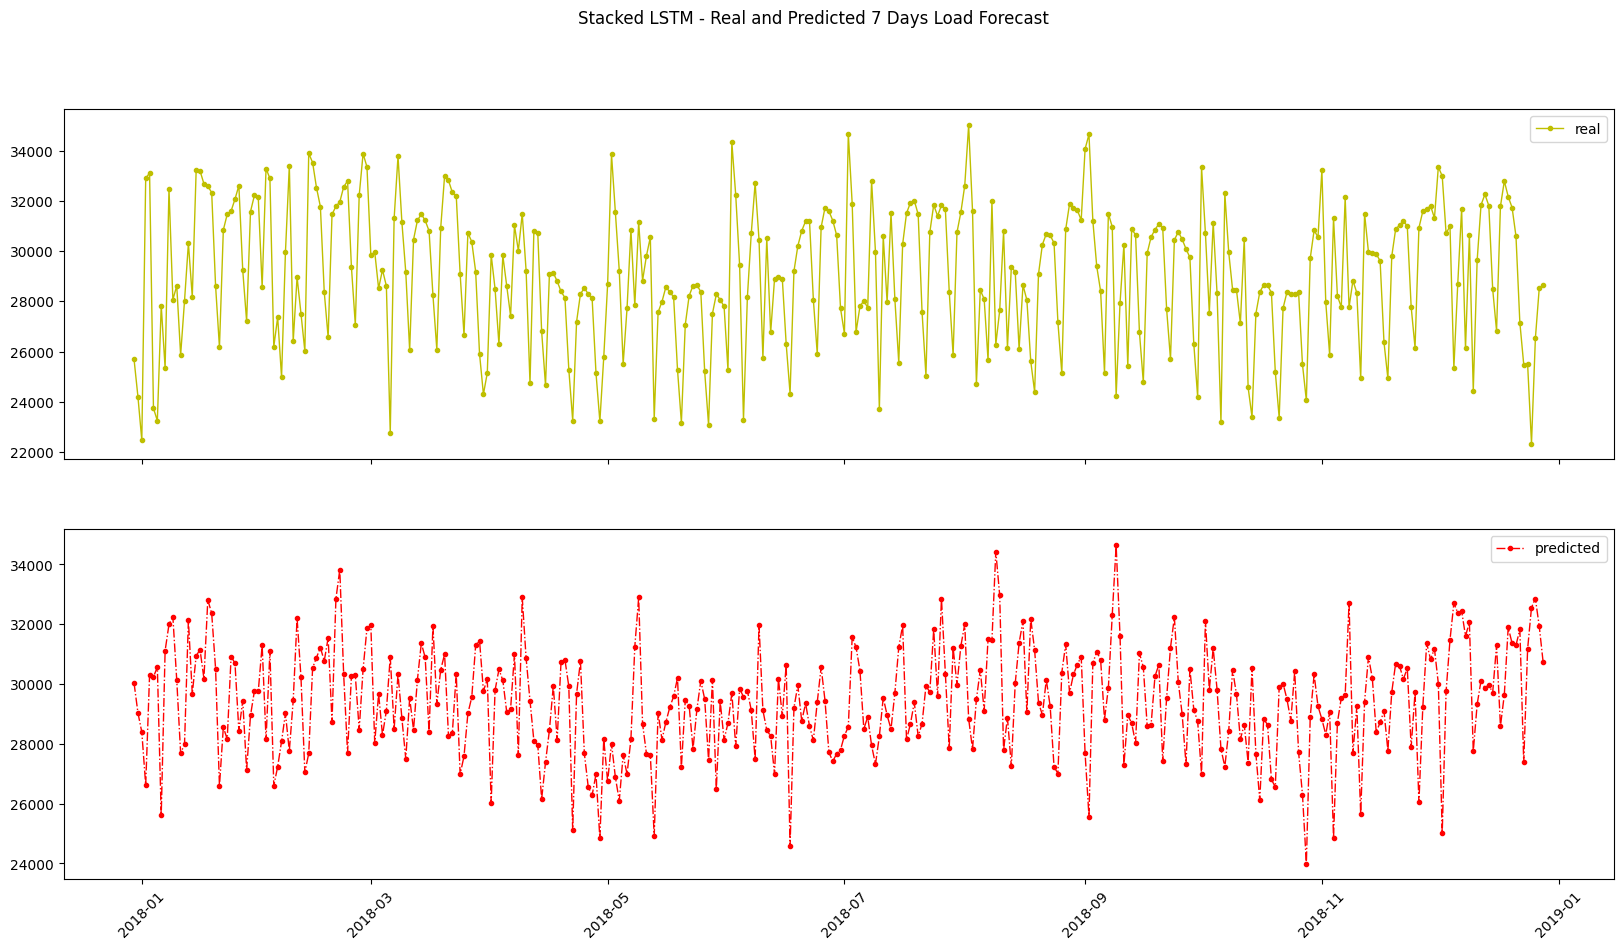

In [37]:
subplots_time_series(df_stacked_lstm_values.index.to_list(),df_stacked_lstm_values["total_load_real_values"],
                          df_stacked_lstm_values["total_load_predicted_values"],"Stacked LSTM")

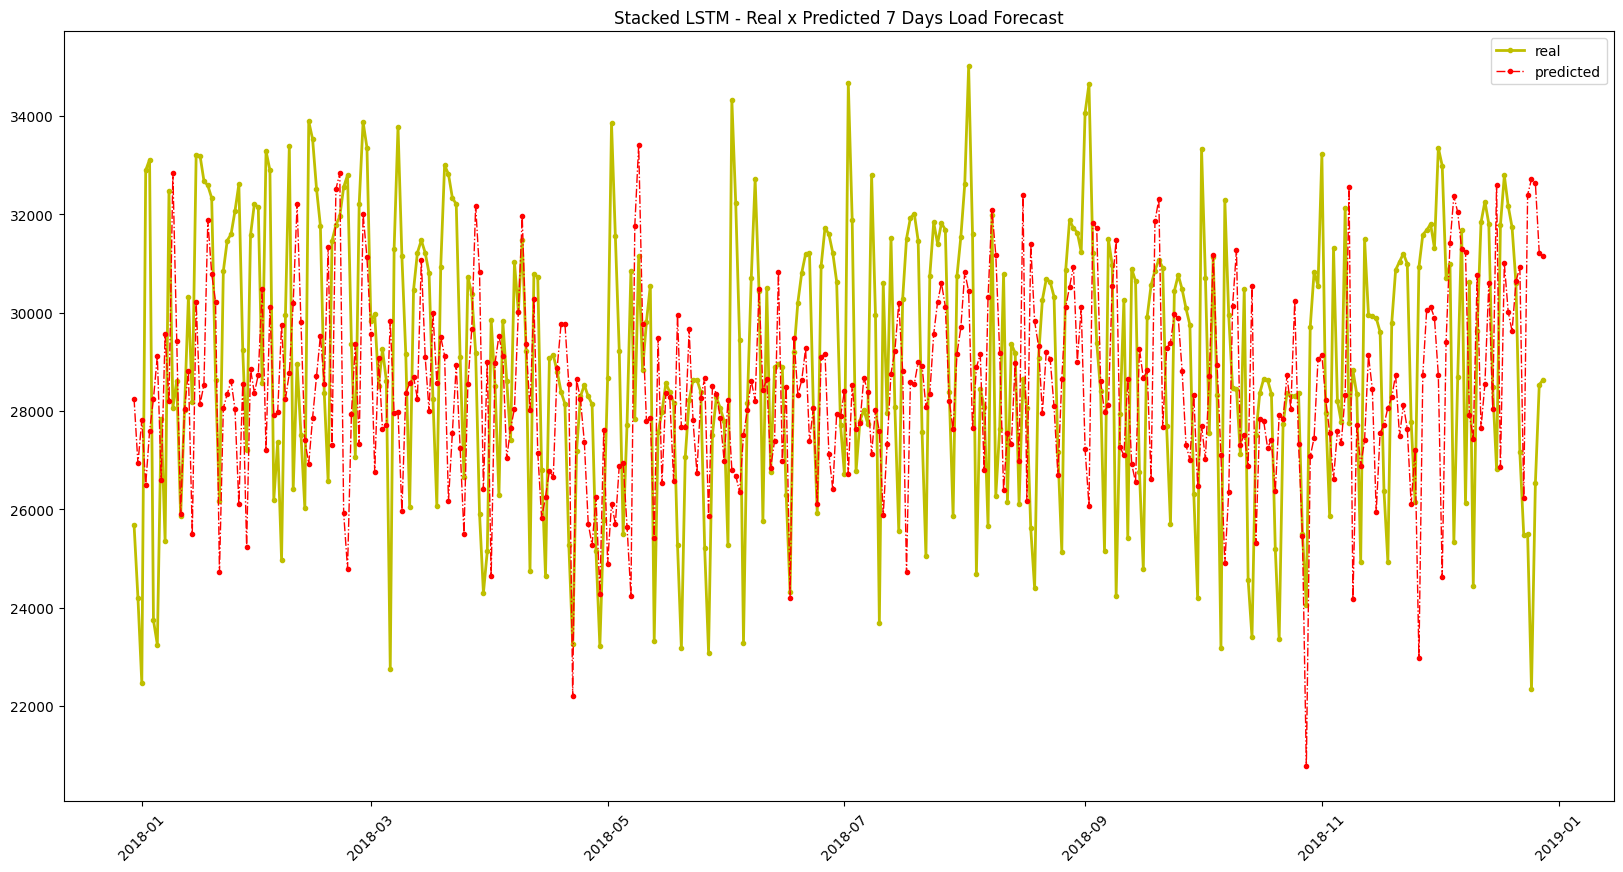

In [38]:
plot_multiple_time_series(df_vanilla_lstm_values.index.to_list(),df_vanilla_lstm_values["total_load_real_values"],
                          df_vanilla_lstm_values["total_load_predicted_values"],"Stacked LSTM")

<a id="bilstm"></a>
### Predictions for Bi LSTM

In [39]:
pred_bilstm_values = predictions_by_model["model_bilstm"][0].squeeze(2)
bilstm_values = np.ravel(inverse_transform(y_test.values.reshape(-1,1),pred_bilstm_values))
print(bilstm_values.shape)
bilstm_values[:10]

(364,)


array([29489.432, 29087.809, 27818.963, 26839.402, 30550.408, 30965.648,
       29387.92 , 27226.684, 29433.305, 29637.508], dtype=float32)

In [40]:
df_bilstm_values = format_predictions(bilstm_values,y_test,y_test.index)


print(f"RMSE for BILSTM: ",mean_squared_error(df_bilstm_values["total_load_real_values"],
     df_bilstm_values["total_load_predicted_values"]))
df_bilstm_values.head()


RMSE for BILSTM:  8370761.235511864


,total_load_predicted_values,total_load_real_values
datetime,,
2017-12-30,29489.431641,25689.041667
2017-12-31,29087.808594,24203.541667
2018-01-01,27818.962891,22462.000000
2018-01-02,26839.402344,32893.458333
2018-01-03,30550.408203,33111.458333


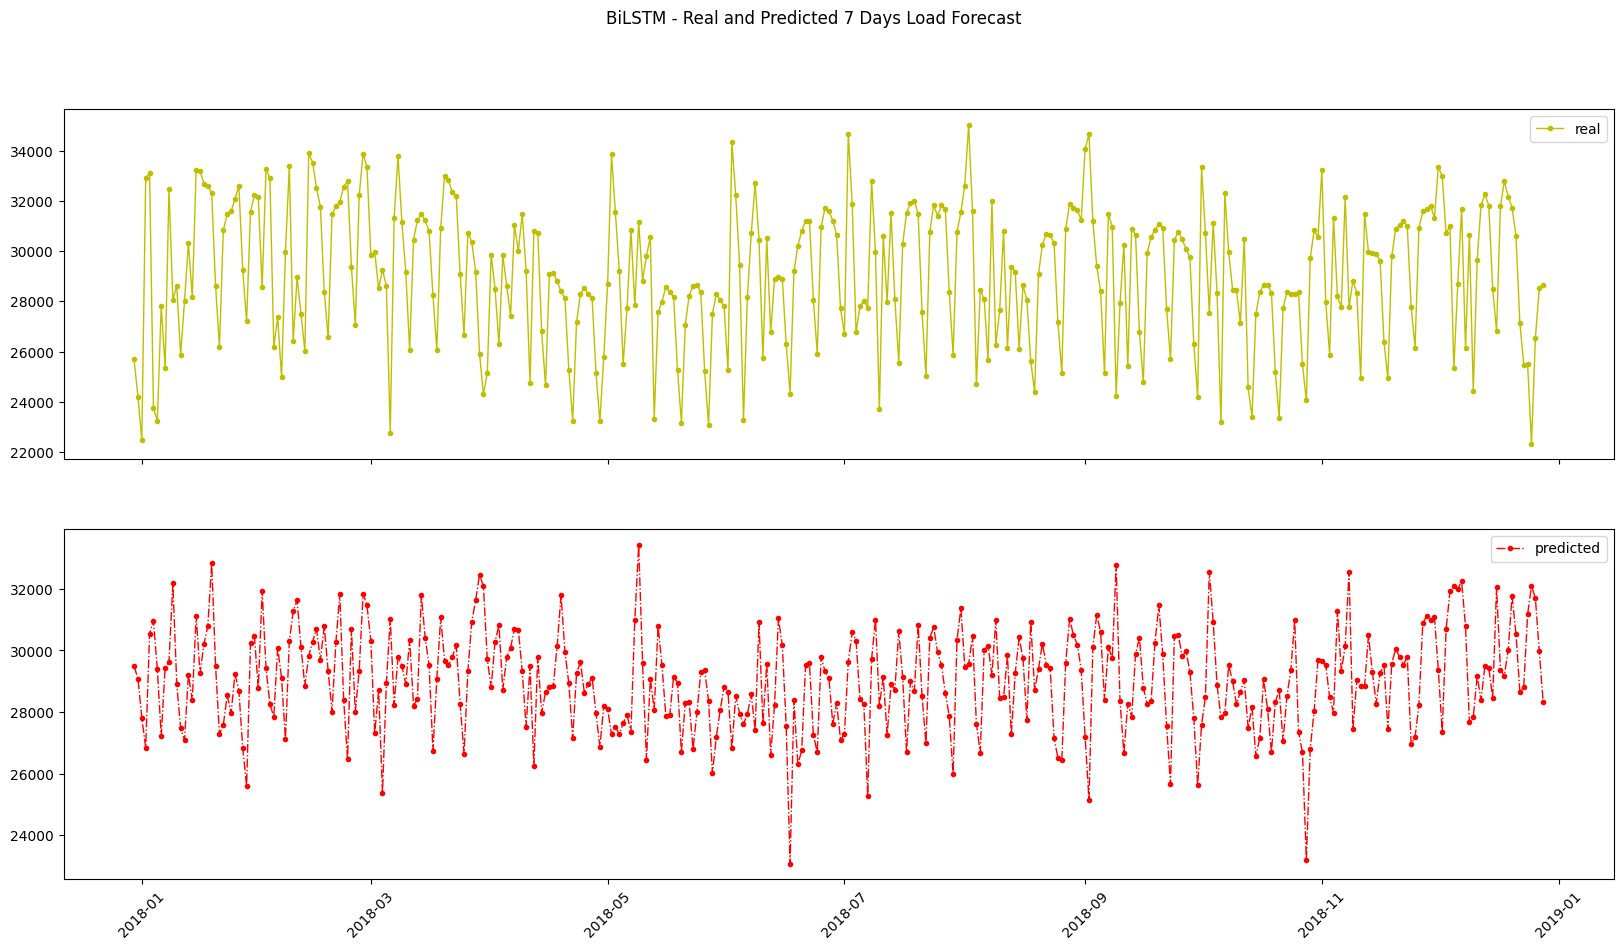

In [41]:
subplots_time_series(df_bilstm_values.index.to_list(),df_bilstm_values["total_load_real_values"],
                          df_bilstm_values["total_load_predicted_values"],"BiLSTM")

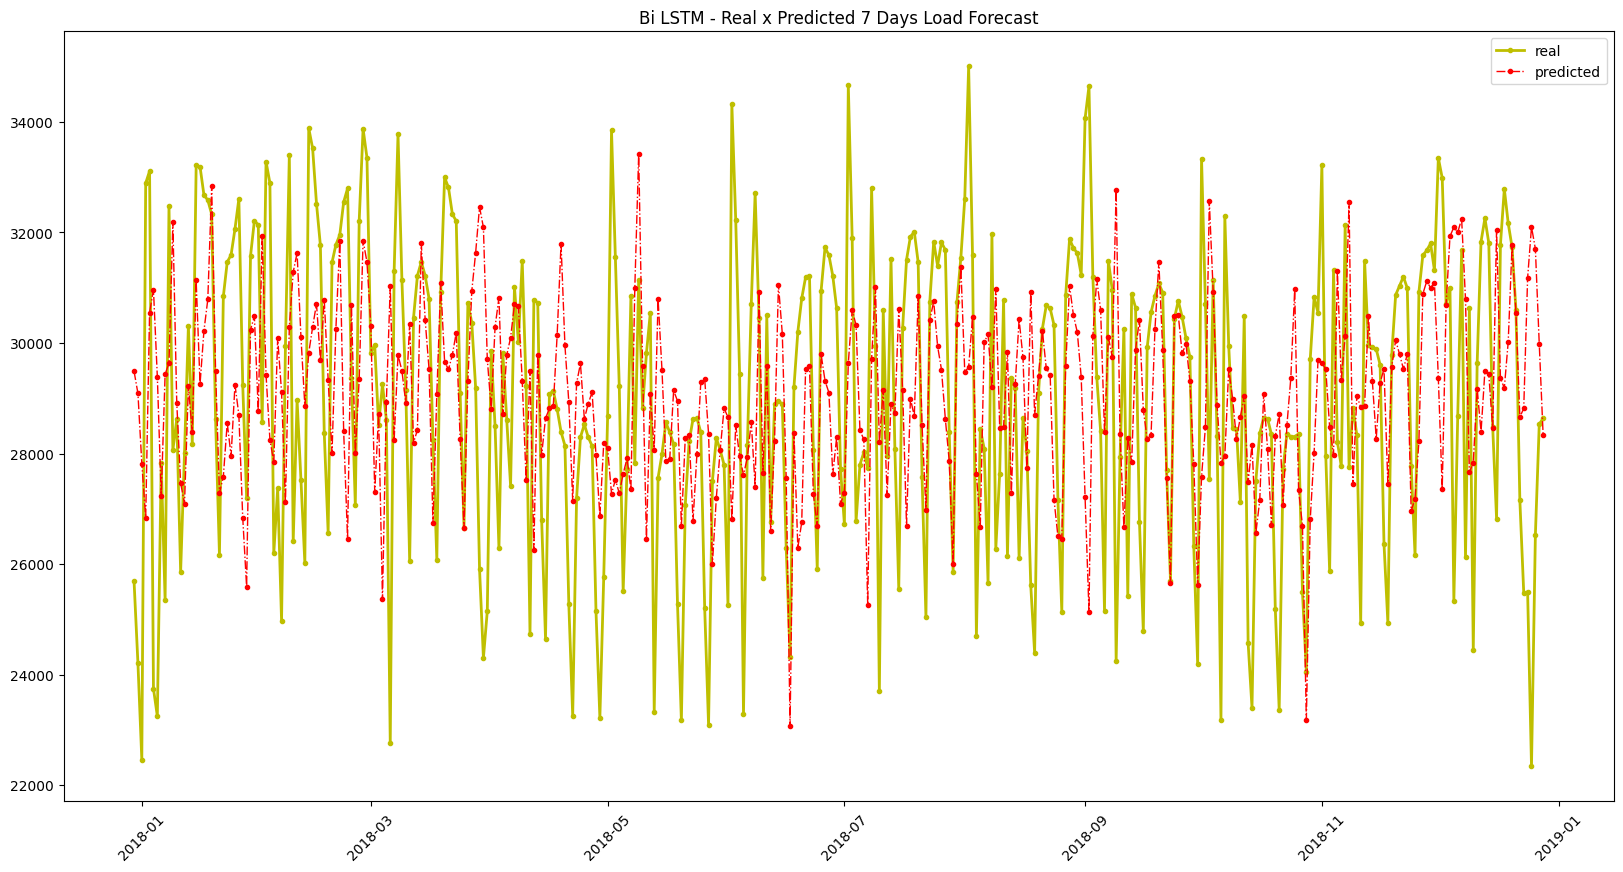

In [42]:
plot_multiple_time_series(df_bilstm_values.index.to_list(),df_bilstm_values["total_load_real_values"],
                          df_bilstm_values["total_load_predicted_values"],"Bi LSTM")

# Exercises

## Exercise: LSTM – CPU vs. GPU & Comparison with MLP

**Objective:**  
Benchmark your LSTM models on both CPU and GPU, measure timings and validation performance, and then compare those results to the MLP case you previously ran.

1. **Prepare the LSTM Environment**  
   - At the top of your notebook, add a variable or flag so that `device = torch.device("cpu")` or `device = torch.device("cuda")` can be selected easily.  
   - Make sure all parts of your data loading, model instantiation, and training loops respect this `device` setting.

2. **Implement Timing for LSTM Training**  
   - In your training loop, record:
     - **Total training time** (wall-clock) from the first epoch to the last.  
     - **Average time per epoch** (and standard deviation, if you like).  
   - For GPU timing, insert `torch.cuda.synchronize()` right before and after your `start_time` and `end_time` calls to capture accurate measurements.  
   - For CPU timing, use Python’s `time.perf_counter()` (or `time.time()`).

3. **Run LSTM on CPU**  
   - Set `device = torch.device("cpu")`.  
   - Train your chosen LSTM architecture (e.g., the best one from your grid search) using the same hyperparameters you used when you evaluated on GPU for LSTM.  
   - Record and save:
     - Total training time (s).  
     - Average time per epoch (s).  
     - Final validation MSE (or whichever loss/metric you used).  
   - Store these results in a Markdown table for later comparison.

4. **Run LSTM on GPU**  
   - Set `device = torch.device("cuda")`.  
   - Repeat the training run with identical code and hyperparameters.  
   - Record:
     - Total training time (s).  
     - Average time per epoch (s).  
     - Final validation MSE (or your chosen metric).  
   - Append these into the same Markdown table.

5. **Create a Summary Table for LSTM (CPU vs. GPU)**  
   For example:

   | Device | Total Training Time (s) | Avg. Time per Epoch (s) | Final Validation MSE |
   |:------:|:-----------------------:|:-----------------------:|:--------------------:|
   |  CPU   |           …             |         … ± …           |         …            |
   |  GPU   |           …             |         … ± …           |         …            |

6. **Compare LSTM vs. MLP**  
   - Retrieve your results from the MLP notebook (grid-search best model) for both CPU and GPU:
     - Total training time (s) and average time per epoch for MLP on CPU.  
     - Total training time (s) and average time per epoch for MLP on GPU.  
     - Final validation MSE (or same metric) for MLP on CPU and GPU.  
   - Create a combined Markdown table that juxtaposes LSTM vs. MLP:

     | Model | Device | Total Training Time (s) | Avg. Time per Epoch (s) | Final Validation MSE |
     |:-----:|:------:|:-----------------------:|:-----------------------:|:--------------------:|
     | MLP   |  CPU   |           …             |         … ± …           |         …            |
     | MLP   |  GPU   |           …             |         … ± …           |         …            |
     | LSTM  |  CPU   |           …             |         … ± …           |         …            |
     | LSTM  |  GPU   |           …             |         … ± …           |         …            |

7. **Write a Comparative Analysis (2–3 Paragraphs)**  
   In the report, address the following points:

   - **Speed Comparison:**  
     1. Compute the speedup factors (CPU→GPU) for both MLP and LSTM (total time and per-epoch time).  
     2. Which model—MLP or LSTM—benefited more (proportionally) from GPU acceleration?  
   - **Validation Performance Consistency:**  
     1. Were the final validation MSEs identical (within numerical tolerance) when running on CPU vs. GPU for each model?  
     2. Compare the best MLP validation MSE to the best LSTM validation MSE (on the same hardware). Which architecture gave lower error? By how much?  
   - **Practical Implications:**  
     1. Discuss scenarios where an LSTM might be worth the extra compute time (e.g., capturing temporal dependencies) versus when an MLP could suffice.  
     2. Reflect on whether the additional training time of LSTM on CPU/GPU is justified by any gain in forecast accuracy compared to the MLP.

8. **(Optional) Inference Latency Comparison**  
   - Measure the time to run a single forward pass (inference) on a fixed-size validation batch for both MLP and LSTM on CPU and GPU.  
   - Report:
     - **Inference latency (ms or s) per batch** for MLP vs. LSTM on each device.  
   - Add a short note on how latency differences might affect real-time deployment decisions.

**Deliverables:**  
- Markdown tables summarizing training times and validation MSEs for:
  1. LSTM (CPU vs. GPU).
  2. MLP vs. LSTM (both devices).  
- A 2–3 paragraph analysis comparing CPU/GPU speedups and MLP vs. LSTM performance.
- (OPTIONAL) Evaluate the LSTM models using additional metrics such as the R² score, and apply k-fold cross-validation for more robust performance assessment.
